# Genome Sequencing
Authors:  
- Minh Duc Ngo  
- Catharina Hoppensack  

This notebook is our own work. Any other sources have been clearly marked and cited.

All authors contributed equally.

## 1 Environment
We worked with the following environment for this jupyter notebook:

- Python version: (3.10.19) 3.11.9  
- OS: Windows 11  
- Environment: Visual Studio Code

In [1]:
#install all basic libraries
%pip install matplotlib pandas numpy scikit-learn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

To be able to run this code on a device with GPU and CPU, the following code block is necessary.

In [3]:
#detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 2 Data Loading and Inspection

_Load the dataset, inspect its structure and dimensions, and briefly describe its content._

First, we print general information about our dataset. The head() function shows us 2 columns and the first 5 rows from which we get a good first impression of how the dataframe is structured. In the sequence column, we see 10 letters composed of A,C,G,T representing the four organic bases, Adenosine, Cytidinem Guanosine and Thymine, that make up the genetic information in our DNA. The label column shows only zeros, which indicates we may need some more information.  

To get more insights about the sample count, any null entries, which data type we are dealing with and the amount of memory consumption, we used the info() function. 


In [4]:
url="https://github.com/thomasmanke/DataSets/raw/refs/heads/main/labeled_sequences.csv.gz"

df = pd.read_csv(url)

display(df.head())




df.info()
print(type(df["sequence"][0]))

,sequence,label
0,GTAGGTAAGC,0
1,GGGGTATTTG,0
2,CACTTCCCTT,0
3,AATCCATAAG,0
4,GGCTTTTGCC,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  20000 non-null  object
 1   label     20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
<class 'str'>



The dataset beholds 20000 samples in which each sequence has 10 letters composed of A,C,G,T and contains no null values.
The sequences are objects and the labels are integers. To be precise the objects are actually Strings because pandas recognizes it as a object except when you have the String dtype active. 

When we simply print the dataframe, we see the first and last 5 entries and the dimensions at the end. Here we see that label can also have the value 1. To check what values we have exactly in the label column, we used unique() function. There are only zeroes and ones.  
To be sure that the dimensions are truly correct, we used the  df.ndim() function, which outputs the dimensions of the dataframe.

In [5]:
print(df)
print("\n")
print("Unique labels: ", df['label'].unique()) #https://note.nkmk.me/en/python-pandas-value-counts/
print("\n")
print(df.ndim) #dimensionen des DataFrames


         sequence  label
0      GTAGGTAAGC      0
1      GGGGTATTTG      0
2      CACTTCCCTT      0
3      AATCCATAAG      0
4      GGCTTTTGCC      0
...           ...    ...
19995  GGGGTGAGAG      0
19996  ACCGCGACTA      0
19997  TCCTGCGAAT      0
19998  GATGCAGGCT      0
19999  ATCATTACGT      1

[20000 rows x 2 columns]


Unique labels:  [0 1]


2


To prevent data leakage, bias and overfitting we get rid of the duplicates, save the sequences as a list, the number of sequences and the length in different variables.


In [6]:



df_noDuplicates = df.drop_duplicates() #remove duplicate sequences
seqs = df_noDuplicates["sequence"].tolist()
y    = df_noDuplicates["label"].values
S = len(seqs)    # number of sequences
L = len(seqs[0]) # same length for all (!!!) sequences

assert all(len(s) == L for s in seqs), "different lenghts detected" #check if there are errors in sequence length 


print(len(df_noDuplicates))


19797


### 3 Data Processing

*Transform the data into a form suitable for MLP input:*
  - *Convert to numpy / torch tensors*
  - *Flatten or reshape inputs as needed*
  - *Split into training and test sets*


A neural network is not able to calculate with letters, therefore we must assign an integer to each letter. The print outputs show the letter version compared to the integer version and the data types used.

In [7]:
#sequence to number conversion, ACGT -> 1234
mapping = str.maketrans({'A':'1','C':'2','G':'3','T':'4'})

seqs_num = [] #new list for numbers
for seq in seqs:
    mapped = seq.translate(mapping)       #"ACGT" -> "1234"
    nums = [int(x) for x in mapped]       #-> [1,2,3,4]
    seqs_num.append(nums)

In [8]:
print(seqs[0:5]) #print first 5 elements of sequence in letters
print(type(seqs))
print(type(seqs[0][0]))
print(seqs_num[0:5]) #print first 5 elelments of sequence in numbers
print(type(seqs_num))
print(type(seqs_num[0][0]))

['GTAGGTAAGC', 'GGGGTATTTG', 'CACTTCCCTT', 'AATCCATAAG', 'GGCTTTTGCC']
<class 'list'>
<class 'str'>
[[3, 4, 1, 3, 3, 4, 1, 1, 3, 2], [3, 3, 3, 3, 4, 1, 4, 4, 4, 3], [2, 1, 2, 4, 4, 2, 2, 2, 4, 4], [1, 1, 4, 2, 2, 1, 4, 1, 1, 3], [3, 3, 2, 4, 4, 4, 4, 3, 2, 2]]
<class 'list'>
<class 'int'>


Now we want to convert our list into a NumPy-array to easily convert to PyTorch-tensors later on.

In [9]:
X_num = np.array(seqs_num, dtype=np.float32)
print(X_num.shape) #(S,L)

(19797, 10)


Here we split the data into test and train data for evaluating our model later.

In [ ]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_num, y, test_size=0.2, random_state=42
)

In [11]:
X_train_tensor_num = torch.tensor(X_train_num, dtype=torch.float32)
X_test_tensor_num  = torch.tensor(X_test_num,  dtype=torch.float32)

#targets have to be float and 2D
y_train_tensor_num = torch.tensor(y_train_num, dtype=torch.float32).unsqueeze(1)
y_test_tensor_num  = torch.tensor(y_test_num,  dtype=torch.float32).unsqueeze(1)

print(f'X_train_tensor.shape: {X_train_tensor_num.shape}  y_train_tensor.shape: {y_train_tensor_num.shape}')
print(f'X_test_tensor.shape:  {X_test_tensor_num.shape}   y_test_tensor.shape:  {y_test_tensor_num.shape}')

X_train_tensor.shape: torch.Size([9898, 10])  y_train_tensor.shape: torch.Size([9898, 1])
X_test_tensor.shape:  torch.Size([9899, 10])   y_test_tensor.shape:  torch.Size([9899, 1])


To be able to compute on our GPU (if available) we need to send the data to the GPU.

In [12]:
#sending all the data directly to the device
X_train_tensor_num = X_train_tensor_num.to(device)
X_test_tensor_num  = X_test_tensor_num.to(device)

y_train_tensor_num = y_train_tensor_num.to(device)
y_test_tensor_num = y_test_tensor_num.to(device)


However, the correct way of translating non integer values into integers for neural networks is by using *one-hot encoding*. This makes sure that the model doesn't assume relations between categories depending on their integer value. It makes each category into a matrix as in the following example:  
A = [1,0,0,0]  
C = [0,1,0,0]  
G = [0,0,1,0]  
T = [0,0,0,1]  

In [13]:
# maps to switch chr <-> int
mapping = dict(zip("ACGT", range(4)))       #zip() creates paires, dict() makes a dictionary
idx2base = {v: k for k, v in mapping.items()} #inverse mapping

# integer encoding of sequence: "AAGTCCA" -> [0,0,2,3,1,1,0]
seqs_int = torch.tensor([[mapping[ch] for ch in s] for s in seqs], dtype=torch.long)

# one-hot encoding of seqs_int: -- Vectorisation
X_hot = F.one_hot(seqs_int, num_classes=4).float() 

# flatten one-hot encoding 
X_hot = X_hot.view(S, 4*L) # length icreases by factor 4
print(f"X.shape: {X_hot.shape}, y.shape: {y.shape}, L = {L}")

X.shape: torch.Size([19797, 40]), y.shape: (19797,), L = 10


For this version we also split it in train and test data.

In [ ]:
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(
    X_hot.numpy(), y, test_size=0.2, random_state=42
)

We convert the data to tensors.

In [15]:
X_train_tensor_hot = torch.tensor(X_train_hot, dtype=torch.float32)
X_test_tensor_hot  = torch.tensor(X_test_hot,  dtype=torch.float32)

#targets have to be float and 2D
y_train_tensor_hot = torch.tensor(y_train_hot, dtype=torch.float32).unsqueeze(1)
y_test_tensor_hot  = torch.tensor(y_test_hot,  dtype=torch.float32).unsqueeze(1)

print(f'X_train_tensor.shape: {X_train_tensor_hot.shape}  y_train_tensor.shape: {y_train_tensor_hot.shape}')
print(f'X_test_tensor.shape:  {X_test_tensor_hot.shape}   y_test_tensor.shape:  {y_test_tensor_hot.shape}')

X_train_tensor.shape: torch.Size([9898, 40])  y_train_tensor.shape: torch.Size([9898, 1])
X_test_tensor.shape:  torch.Size([9899, 40])   y_test_tensor.shape:  torch.Size([9899, 1])


To be more memory efficient we can use batches that are calculated one after the other.
We split the train data into 248 batches with 64 samples.
The test data is split into 62 batches with 64 samples.

In [16]:
batch_size = 64 #split data into batches of 64 samples

train_ds = TensorDataset(X_train_tensor_hot, y_train_tensor_hot) #combines data and targets into a dataset
test_ds  = TensorDataset(X_test_tensor_hot,  y_test_tensor_hot)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) #shuffle the data every epoch, creates batches
test_loader  = DataLoader(test_ds,  batch_size=batch_size)
print(len(train_loader))
print(len(test_loader))

155
155


## 4 Model Definition
_Define an appropriate MLP architecture (e.g with PyTorch nn.Sequential). Include number of layers, activation functions, and output dimensions. Report structure and number of parameters._

### Model 1 (NO one-hot encoding & NO batches)

For our first model we have five layers with ReLU as our activation function and Dropout with delta as our parameter.  
Giving our model the normal sequence length, 10, as input and create a layer with 128 neurons. Using the created layers and neurons we create another layer with 64 and do it again for a layer with 32 neurons. Lastly with the 32 neuron layer we create 1 neuron which will be our output neuron.  
After the creation of each layer, except the output-layer, the neurons will be given to ReLU() where any negative number will turn to 0.  
Then, depending on the parameter(delta), dropout will deactivate a number of neurons randomly. It won't be able to rely on individual neurons and is forced to learn more general features. 

In [17]:
delta = 0.2
model_num = nn.Sequential(
    nn.Linear(L, 128),
    nn.ReLU(),            
    nn.Dropout(delta),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(delta),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(delta),
    nn.Linear(32, 1)#output layer "Binary Classification can be realized with single output neuron" s.Vorlesungsfolien 
) 

model_num = model_num.to(device) #sending to GPU if available

Our second model is similar to the first model. The difference is that we use SiLU instead of ReLU and the input is multiplied by 4 due to the one-hot encoding. SiLU is similar to ReLU but instead of turning negative numbers to 0 it will only be damped a little and prevents dead neurons. 

### Model 2 (one-hot encoding + batches)

In [18]:
n_in = 4*L
delta = 0.2

model_hot = nn.Sequential(
    nn.Linear(n_in, 128),
    nn.SiLU(),             #using SiLU for a more smoothed output rather than simply 0 for negative values --> helps to avoid dead neurons and for comparison to ReLU
    nn.Dropout(delta),
    nn.Linear(128, 64),
    nn.SiLU(),
    nn.Dropout(delta),
    nn.Linear(64, 32),
    nn.SiLU(),
    nn.Dropout(delta),
    nn.Linear(32, 1)
)

model_hot = model_hot.to(device)  #sending to GPU if available

## 5 Model Training
*Implement a full training loop including:*
  - *Loss function and optimizer*
  - *Iterative training with loss updates*
  - *Plot the loss history*


Now we train our models with the train data we prepared before. The first model gets the "normal" trainset, epochs are set to 1000 and both models use Adam as optimizer and BCEWithLogitsLoss as loss function.

In [19]:
n_epochs = 1000
losses = []

#standard neural network loss function for binary classification
#Sigmoid included
#BCE = Binary Cross Entropy = compares prediction with actual label
loss_func_BCE = nn.BCEWithLogitsLoss()
#standard neural network optimizer, lernrate 0.001
optimizer_Adam_num = torch.optim.Adam(model_num.parameters(), lr=0.001)

model_num.train()
for epoch in range(n_epochs):
    y_pred = model_num(X_train_tensor_num)
    loss = loss_func_BCE(y_pred, y_train_tensor_num)
    optimizer_Adam_num.zero_grad()                   #Gradienten auf 0 setzen, damit sie sich nicht aufsummieren
    loss.backward()                         #Gradienten berechnen
    optimizer_Adam_num.step()
    losses.append(loss.item())

The other Model has 100 epoochs and will be using the hot encoded train data while also loading batches.

In [20]:
loss_func_BCE = nn.BCEWithLogitsLoss()
#standard neural network optimizer, lernrate 0.001
optimizer_Adam_hot = torch.optim.Adam(model_hot.parameters(), lr=0.001)

n_epochs = 100
losses_hot = []

for epoch in range(n_epochs):
    model_hot.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:            #für jeden Batch, mache das innerhalb der Schleife
        X_batch = X_batch.to(device)                 #batchdaten an GPU senden, falls vorhanden
        y_batch = y_batch.to(device)

        y_pred = model_hot(X_batch)
        loss = loss_func_BCE(y_pred, y_batch)

        optimizer_Adam_hot.zero_grad()               #Gradienten auf 0 setzen, damit sie sich nicht aufsummieren
        loss.backward()                              #Gradienten berechnen
        optimizer_Adam_hot.step()                    #Gewichte updaten

        running_loss += loss.item()



    epoch_loss = running_loss / len(train_loader)  
    losses_hot.append(epoch_loss)

## 6 Model Evaluation
*Generate predictions on the test set and compute suitable metrics:*  
- *Regression*: MSE or R²* 
- *Classification: overall accuracy and class-wise metrices*

Now we evaluate our models.
 

Both models shows a better loss in the test data than the train data. This indicates that it predicts even better for unknown data than for the train data and is NOT overfitted. In addition, the losses are very small and practically 0 for both test and train data.

In [21]:
model_num.eval()
with torch.no_grad():
    y_prediction_num = model_num(X_test_tensor_num)                               #using test data to evaluate
    test_loss_num = loss_func_BCE(y_prediction_num, y_test_tensor_num).item()     #using the before defined loss function
print("Final train loss:", losses[-1])
print("Test loss:", test_loss_num)

Final train loss: 0.04663809388875961
Test loss: 0.053272150456905365


In [22]:
model_hot.eval()
with torch.no_grad():
    y_prediction_hot = model_hot(X_train_tensor_hot.to(device))                               #using test data to evaluate
    test_loss_hot = loss_func_BCE(y_prediction_hot, y_train_tensor_hot.to(device)).item()     #using the before defined loss function
print("Final train loss:", losses_hot[-1])
print("Test loss:", test_loss_hot)

Final train loss: 0.0007823690196957959
Test loss: 2.220403985120356e-06


## 7 Visualization
_Plot training and validation loss curves, and visualize model results e.g. predicted vs. true values, or confusion matrices._

To be able to visualize the predicted labels, we need to convert the predicted logits into 0/1 values.

In [23]:
model_num.eval()
with torch.no_grad():
    logits_num = model_num(X_test_tensor_num)
    probs_num  = torch.sigmoid(logits_num)
    preds_num  = (probs_num > 0.5).int()

In [24]:
model_hot.eval()
with torch.no_grad():
    logits_hot = model_hot(X_test_tensor_hot.to(device))
    probs_hot  = torch.sigmoid(logits_hot)
    preds_hot  = (probs_hot > 0.5).int()

The following graphs show the training loss functions for model 1 and model 2 in comparison.  
Model 1 needs a lot more epochs to be at a very low loss.

Due to the artificially produced distances bases, the model must compensate for this and therefore needs more time learning.  
In addition due to the calculation in batches the model updates the gradient as often as there are batches in one epoch.  
Also the SiLU a tiny impact on the loss curve.

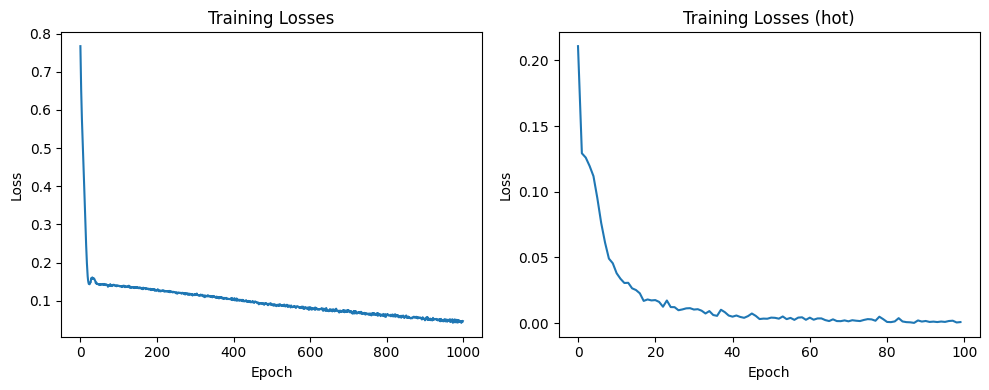

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: losses
axes[0].plot(losses)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Losses")

# Rihgt: losses_hot
axes[1].plot(losses_hot)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training Losses (hot)")

plt.tight_layout()
plt.show()

In the following plot we can see both graphs together for a better visualization and comparison.

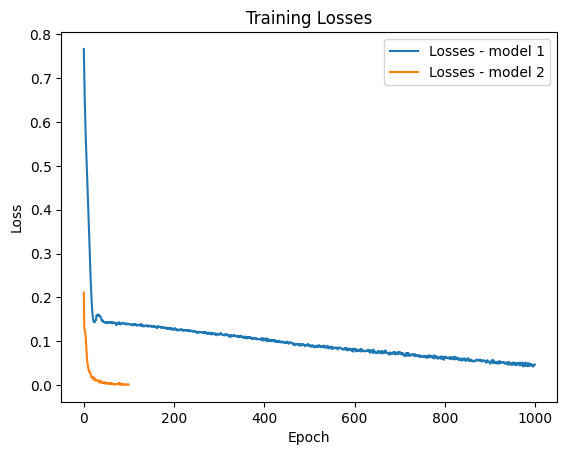

In [26]:
plt.plot(losses, label="Losses - model 1")
plt.plot(losses_hot, label="Losses - model 2")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

Now let's take a closer look at the labels that were actually predicted.  
Out of all samples in the test data only a small percentage are label one. Therefore  
The first model managed to predict nearly everything correct.

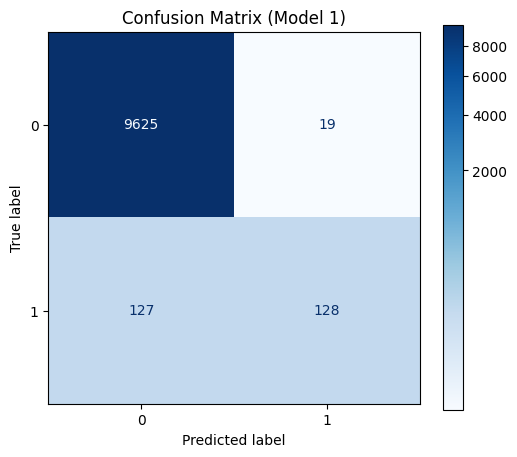

In [27]:
y_true_num = y_test_tensor_num.cpu().numpy().astype(int).ravel()
preds_num = preds_num.cpu().numpy().astype(int).ravel()
cm = confusion_matrix(y_true_num, preds_num)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True, im_kw={"norm": colors.PowerNorm(gamma=0.3)})
plt.title("Confusion Matrix (Model 1)")
plt.show()

In [28]:
total_cm = cm.sum()
correct_cm = np.trace(cm)
mis_total_cm = total_cm - correct_cm

print(f"Total samples: {total_cm}")
print(f"Correct: {correct_cm}  ({correct_cm/total_cm:.2%})")
print(f"Misclassified: {mis_total_cm}  ({mis_total_cm/total_cm:.2%})")

Total samples: 9899
Correct: 9753  (98.53%)
Misclassified: 146  (1.47%)


The second model managed to get everything correct.

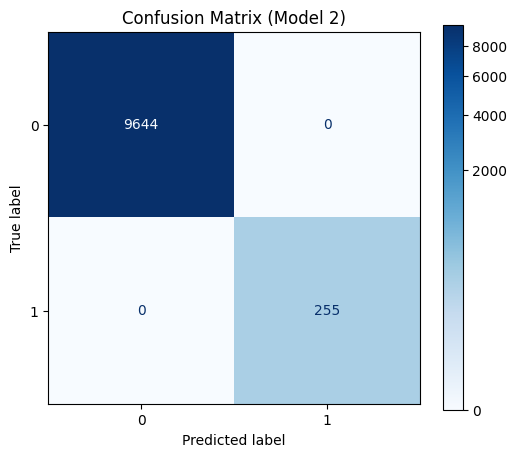

In [29]:
y_true_hot = y_test_tensor_hot.cpu().numpy().astype(int).ravel()
preds_hot = preds_hot.cpu().numpy().astype(int).ravel()

cm_hot = confusion_matrix(y_true_hot, preds_hot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_hot)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True, im_kw={"norm": colors.PowerNorm(gamma=0.3)})
plt.title("Confusion Matrix (Model 2)")
plt.show()

In [30]:
total_cm_hot = cm_hot.sum()
correct_cm_hot = np.trace(cm_hot)
mis_total_cm_hot = total_cm_hot - correct_cm_hot

print(f"Total samples: {total_cm_hot}")
print(f"Correct: {correct_cm_hot}  ({correct_cm_hot/total_cm_hot:.2%})")
print(f"Misclassified: {mis_total_cm_hot}  ({mis_total_cm_hot/total_cm_hot:.2%})")

Total samples: 9899
Correct: 9899  (100.00%)
Misclassified: 0  (0.00%)


## 8 Discussion 
_Provide a short reflection on model behavior and performance._

Both models achieve very low training losses. 
Model 1 has a low error rate even though it had to compensate for the numeric translation of the letters.
Due to the small number of datasets for label one, the model probably had bigger a problem with predicting it correctly.  

Model two had the advantage of learning with the one-hot encoded data and batches.
Therefore the model is able to perfectly predict the outcome. 
We also tried to divide the test and training data into equal parts. The first model showed a much higher error rate while the second model stayed the same and was still able to predict it 100% correct.
